In [1]:
import pandas as pd
import tensorflow
import numpy as np
from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from keras.applications import MobileNetV2

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
base_model=MobileNetV2(include_top=False, weights="imagenet", input_shape=(224,224,3))

9406464/9406464 [==============================] - 0s 0us/step


In [3]:
from keras.layers import LSTM, Reshape

model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3, 3), activation = 'relu'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.40))
model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(7, activation='sigmoid'))


In [6]:
data=pd.read_csv("/content/drive/MyDrive/HAM_10000Dataset/HAM10000_metadata.csv")
data['image_full_name']=data['image_id']+'.jpg'
X= data[['image_full_name','dx','lesion_id']]

In [7]:
X.sample(5)

,image_full_name,dx,lesion_id
2321,ISIC_0031270.jpg,vasc,HAM_0006889
6370,ISIC_0026943.jpg,nv,HAM_0003440
8589,ISIC_0027308.jpg,nv,HAM_0003496
476,ISIC_0024426.jpg,bkl,HAM_0001597
3710,ISIC_0025461.jpg,nv,HAM_0000852


In [8]:
from sklearn.model_selection import train_test_split
Y= X.pop('dx').to_frame()
X_train, X_test, Y_train, Y_test  =train_test_split(X,Y, test_size=0.2, random_state=40)
X_train,X_val,Y_train,Y_val       =train_test_split(X_train,Y_train, test_size=0.2, random_state=40)

In [10]:
train=pd.concat([X_train,Y_train],axis=1)
val=pd.concat([X_val,Y_val],axis=1)
test=pd.concat([X_test,Y_test],axis=1)

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
encoder.fit(val['dx'])
name_as_indexes_train=encoder.transform(val['dx'])
val['label']=name_as_indexes_train

In [12]:
encoder= LabelEncoder()
encoder.fit(test['dx'])
name_as_indexes_test=encoder.transform(test['dx'])
test['label']=name_as_indexes_test

In [13]:
!pip install keras_preprocessing

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.2 MB/s eta 0:00:00


In [18]:
from keras_preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rescale = 1./255,
                                     rotation_range=10,
                                     zoom_range = 0.1,
                                     width_shift_range=0.0, height_shift_range=0.00)

In [17]:
train_data= train_generator.flow_from_dataframe(dataframe=train,x_col="image_full_name",y_col="dx",
                                                batch_size=32,directory="/content/drive/MyDrive/HAM_10000Dataset/HAM10000_images_part_1",
                                                shuffle=True,class_mode="categorical",target_size=(224,224))


Found 3199 validated image filenames belonging to 7 classes.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 3210 invalid image filename(s) in x_col="image_full_name". These filename(s) will be ignored.
  warnings.warn(


In [19]:
test_generator=ImageDataGenerator(rescale= 1./255,rotation_range=10,
                                  zoom_range= 0.1,
                                  width_shift_range=0.0, height_shift_range=0.02)

In [20]:
test_data= test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                                directory="/content/drive/MyDrive/HAM_10000Dataset/HAM10000_images_part_2",
                                                shuffle=True,class_mode=None,target_size=(224,224))

Found 776 validated image filenames.


/usr/local/lib/python3.10/dist-packages/keras_preprocessing/image/dataframe_iterator.py:279: UserWarning: Found 827 invalid image filename(s) in x_col="image_full_name". These filename(s) will be ignored.
  warnings.warn(


In [21]:
val_data=test_generator.flow_from_dataframe(dataframe=val,x_col="image_full_name",y_col="dx",
                                            directory="/content/drive/MyDrive/HAM_10000Dataset/HAM10000_images_part_2",
                                            batch_size=64,shuffle= False,class_mode="categorical",target_size=(224,224))

Found 776 validated image filenames belonging to 7 classes.


In [22]:
from keras.callbacks import ReduceLROnPlateau
learning_control = ReduceLROnPlateau(monitor='val_acc',patience=3, verbose=1, factor= .5, min_lr=0.0001)

In [23]:
from keras.optimizers import Adam,SGD
sgd = optimizers.SGD(learning_rate = 0.01, clipvalue = 0.5)
model.compile(optimizer=sgd, loss="categorical_crossentropy",metrics=["accuracy"])

In [25]:

history = model.fit_generator(generator=train_data,
                              steps_per_epoch=train_data.samples//train_data.batch_size,
                              validation_data=val_data,
                              verbose=1,
                              validation_steps=val_data.samples//val_data.batch_size,
                              epochs=5,callbacks=[learning_control])

<ipython-input-25-098098b2f364>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_data,


Epoch 1/5
99/99 [==============================] - ETA: 0s - loss: 1.0886 - accuracy: 0.6628

99/99 [==============================] - 900s 9s/step - loss: 1.0886 - accuracy: 0.6628 - val_loss: 2.0376 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 2/5
99/99 [==============================] - ETA: 0s - loss: 0.9072 - accuracy: 0.6997

99/99 [==============================] - 458s 5s/step - loss: 0.9072 - accuracy: 0.6997 - val_loss: 1.3714 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 3/5
99/99 [==============================] - ETA: 0s - loss: 0.8085 - accuracy: 0.7272

99/99 [==============================] - 467s 5s/step - loss: 0.8085 - accuracy: 0.7272 - val_loss: 1.4556 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 4/5
99/99 [==============================] - ETA: 0s - loss: 0.7536 - accuracy: 0.7414

99/99 [==============================] - 465s 5s/step - loss: 0.7536 - accuracy: 0.7414 - val_loss: 1.9773 - val_accuracy: 0.6562 - lr: 0.0100
Epoch 5/5
99/99 [==============================] - ETA: 0s - loss: 0.6930 - accuracy: 0.7588

99/99 [==============================] - 473s 5s/step - loss: 0.6930 - accuracy: 0.7588 - val_loss: 1.3533 - val_accuracy: 0.6536 - lr: 0.0100


In [26]:
model.save('model123.h5')

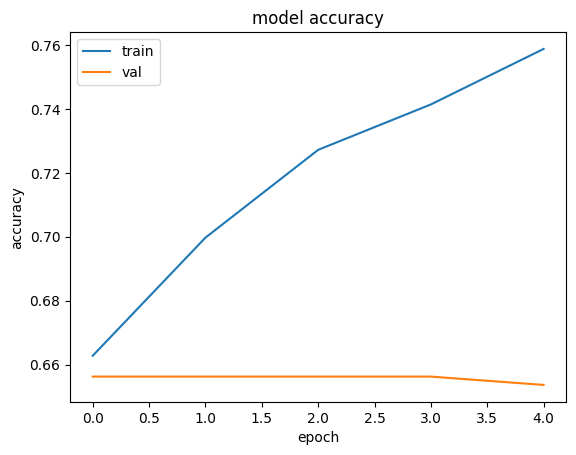

In [27]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

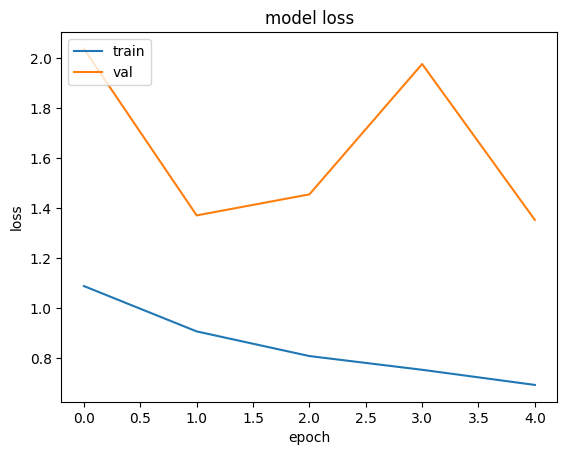

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','val'], loc='upper left')
plt.show()

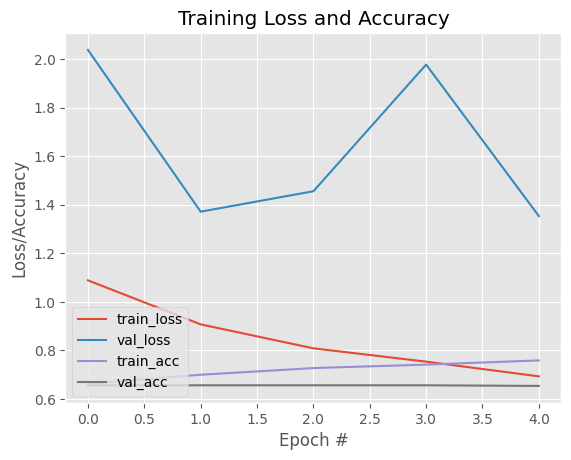

In [33]:
N = 5
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [45]:
test_data.reset()
predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)
y_pred= np.argmax(predictions,axis=1)

<ipython-input-45-3df7b2f2e156>:2: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  predictions = model.predict_generator(test_data, steps=test_data.samples/test_data.batch_size,verbose=1)


24/24 [==============================] - 28s 1s/step


In [46]:
c=np.where(y_pred == name_as_indexes_test)

<ipython-input-46-74e3a1d6fea6>:1: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  c=np.where(y_pred == name_as_indexes_test)


In [41]:
np.count_nonzero(c)

0

In [43]:
print("Test Accuracy: ",(np.count_nonzero(c)/len(name_as_indexes_test))*100)

Test Accuracy:  0.0


In [ ]:
from sklearn.metrics import classification_report

report = classification_report(name_as_indexes_test, y_pred)

print(report)